# Importing Libraries




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import tensorflow as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense , Input ,MaxPooling2D  , Conv2D , Flatten , Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.utils import plot_model


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading Dataset


In [ ]:
dataset_path = "/content/drive/MyDrive/Final_year_project/dataset"
train_path = "/content/drive/MyDrive/Final_year_project/dataset/train"
test_path = "/content/drive/MyDrive/Final_year_project/dataset/test"

In [ ]:
len(os.listdir(os.path.join(train_path , "healthy")))

648

In [ ]:

len(os.listdir(os.path.join(test_path , "healthy")))

270

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = train_path ,
                                                               validation_split = 0.1 ,
                                                               subset = "training" , seed = 123)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = train_path ,
                                                               validation_split = 0.1 ,
                                                               subset = "validation" ,
                                                               seed = 123)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = test_path)

Found 1296 files belonging to 2 classes.
Using 1167 files for training.
Found 1296 files belonging to 2 classes.
Using 129 files for validation.
Found 540 files belonging to 2 classes.


# Training Pre trained VGG16 model with Global Pooling Average

In [ ]:
base_model_vgg = tf.keras.applications.VGG16(include_top = False , input_shape = (256 , 256 , 3))
base_model_vgg.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape = (256 , 256 , 3))
model_vgg = base_model_vgg(input)
model_vgg = GlobalAveragePooling2D()(model_vgg)
output_vgg = Dense(1 , activation = "sigmoid" )(model_vgg)
model_vgg = Model(inputs = input , outputs = output_vgg)

In [ ]:
model_vgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


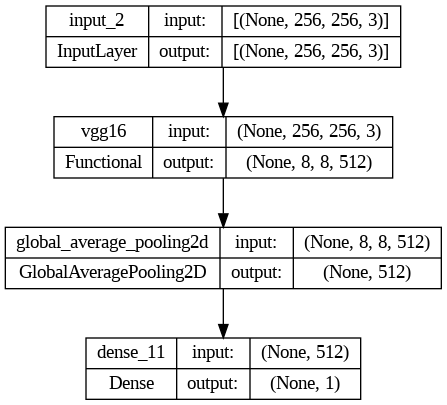

In [ ]:
plot_model(model_vgg , show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/VGG16_with_GPA.png")

In [ ]:
model_vgg.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
os.makedirs("/content/drive/MyDrive/Final_year_project/models" , exist_ok = True)

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/vgg16_with_global_average_pooling";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)

In [ ]:
history = model_vgg.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30


In [ ]:
model_vgg.save("/content/drive/MyDrive/Final_year_project/models/vgg16_with_global_average_pooling.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/VGG16_with_global_average_pooling.csv")


In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("VGG16 with GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/VGG16_with_GPA_accuracy.jpg")

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("VGG16 with GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/VGG16_with_GPA_loss.jpg")

In [ ]:
model_vgg.evaluate(test_ds)

# Training Pre trained VGG16 model with Flattening Layer

In [ ]:
base_model_vgg = tf.keras.applications.VGG16(include_top = False , input_shape = (256 , 256 , 3))
base_model_vgg.trainable = False

In [ ]:
input = Input(shape = (256 , 256 , 3))
model_vgg = base_model_vgg(input)
model_vgg = Flatten()(model_vgg)
model_vgg = Dense(128 , activation = "relu" , name = "Dense_128")(model_vgg)
output_vgg = Dense(1 , activation = "sigmoid", name = "vgg_output")(model_vgg)
model_vgg = Model(inputs = input , outputs = output_vgg)

In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 Dense_128 (Dense)           (None, 128)               4194432   
                                                                 
 vgg_output (Dense)          (None, 1)                 129       
                                                                 
Total params: 18,909,249
Trainable params: 4,194,561
Non-trainable params: 14,714,688
_________________________________________________________________


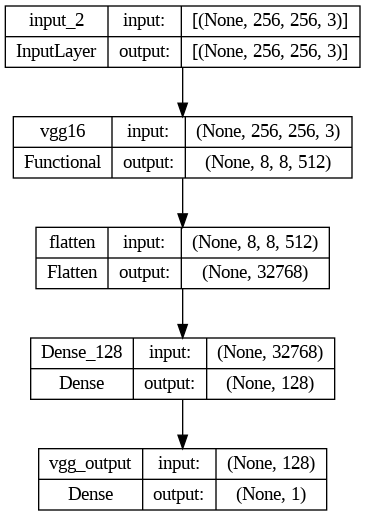

In [ ]:
plot_model(model_vgg , show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/VGG16_with_Dense_Architecture.png")

In [ ]:
model_vgg.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/vgg16_with_Dense_architecture";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)


In [ ]:
history = model_vgg.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 4.2318 - accuracy: 0.7712

37/37 [==============================] - 183s 4s/step - loss: 4.2318 - accuracy: 0.7712 - val_loss: 0.3227 - val_accuracy: 0.8450
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9417

37/37 [==============================] - 12s 294ms/step - loss: 0.1406 - accuracy: 0.9417 - val_loss: 0.1399 - val_accuracy: 0.9380
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9786

37/37 [==============================] - 12s 309ms/step - loss: 0.0784 - accuracy: 0.9786 - val_loss: 0.1342 - val_accuracy: 0.9535
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9837

37/37 [==============================] - 11s 286ms/step - loss: 0.0314 - accuracy: 0.9837 - val_loss: 0.0976 - val_accuracy: 0.9612
Epoch 5/30
37/37 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9871

37/37 [==============================] - 12s 298ms/step - loss: 0.0195 - accuracy: 0.9871 - val_loss: 0.0971 - val_accuracy: 0.9612
Epoch 6/30
37/37 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9931

37/37 [==============================] - 11s 282ms/step - loss: 0.0162 - accuracy: 0.9931 - val_loss: 0.0937 - val_accuracy: 0.9612
Epoch 7/30
37/37 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9966

37/37 [==============================] - 12s 281ms/step - loss: 0.0156 - accuracy: 0.9966 - val_loss: 0.0938 - val_accuracy: 0.9690
Epoch 8/30
37/37 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9966

37/37 [==============================] - 12s 278ms/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 0.0988 - val_accuracy: 0.9612
Epoch 9/30
37/37 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9949

37/37 [==============================] - 11s 288ms/step - loss: 0.0129 - accuracy: 0.9949 - val_loss: 0.0988 - val_accuracy: 0.9535


In [ ]:
model_vgg.save("/content/drive/MyDrive/Final_year_project/models/vgg16_with_dense_architecture.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/VGG16_with_dense_architecture.csv")


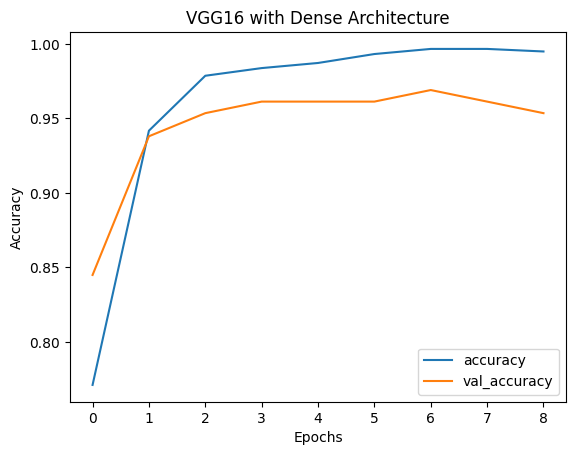

In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("VGG16 with Dense Architecture")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/VGG16_with_dense_architecture_accuracy.jpg")

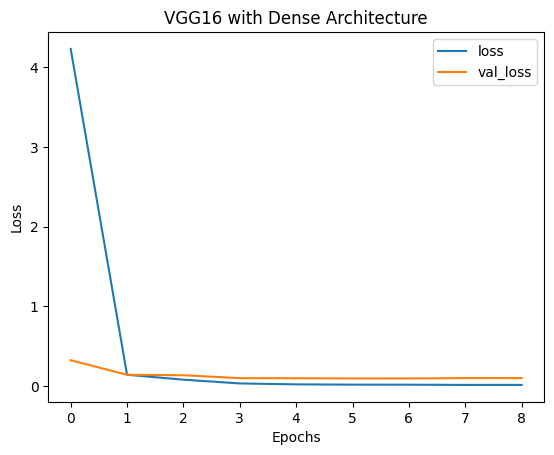

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("VGG16 with Dense Architecture")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/VGG16_with_dense_architecure_loss.jpg")

# Training Mobile Net V2

In [ ]:
base_model_mobilenet = tf.keras.applications.MobileNetV2(include_top = False , input_shape = (256 , 256 , 3))
base_model_mobilenet.trainable = False

In [ ]:
input = Input(shape = (256 , 256 , 3))
model_mobilenet = base_model_mobilenet(input)
model_mobilenet = Flatten()(model_mobilenet)
model_mobilenet = Dense(128 , activation = "relu")(model_mobilenet)
output_mobilenet = Dense(1 , activation = "sigmoid")(model_mobilenet)
model_mobilenet= Model(inputs = input , outputs = output_mobilenet)

In [ ]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 128)               10485888  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,744,001
Trainable params: 10,486,017
Non-trainable params: 2,257,984
_________________________________________

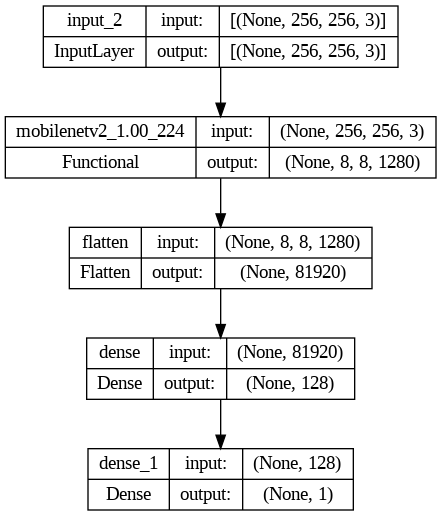

In [ ]:
plot_model(model_mobilenet, show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/MobileNetV2_with_Dense_Architecture.png")

In [ ]:
model_mobilenet.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/mobilenetV2_with_Dense_architecture";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)


In [ ]:
history = model_mobilenet.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 5.0899 - accuracy: 0.5133

37/37 [==============================] - 326s 9s/step - loss: 5.0899 - accuracy: 0.5133 - val_loss: 0.8675 - val_accuracy: 0.5891
Epoch 2/30
36/37 [============================>.] - ETA: 0s - loss: 0.6098 - accuracy: 0.6727

37/37 [==============================] - 33s 889ms/step - loss: 0.6105 - accuracy: 0.6727 - val_loss: 0.5710 - val_accuracy: 0.7287
Epoch 3/30
36/37 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.7873

37/37 [==============================] - 29s 750ms/step - loss: 0.4658 - accuracy: 0.7849 - val_loss: 0.5717 - val_accuracy: 0.6977
Epoch 4/30
36/37 [============================>.] - ETA: 0s - loss: 0.4218 - accuracy: 0.7943

37/37 [==============================] - 37s 985ms/step - loss: 0.4209 - accuracy: 0.7961 - val_loss: 0.5855 - val_accuracy: 0.6977
Epoch 5/30
36/37 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8047

37/37 [==============================] - 36s 948ms/step - loss: 0.4076 - accuracy: 0.8038 - val_loss: 0.5314 - val_accuracy: 0.7209
Epoch 6/30
36/37 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8837

37/37 [==============================] - 34s 921ms/step - loss: 0.3103 - accuracy: 0.8809 - val_loss: 0.5364 - val_accuracy: 0.7287
Epoch 7/30
36/37 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8845

37/37 [==============================] - 28s 747ms/step - loss: 0.2951 - accuracy: 0.8826 - val_loss: 0.6910 - val_accuracy: 0.6124
Epoch 8/30
36/37 [============================>.] - ETA: 0s - loss: 0.2809 - accuracy: 0.8854

37/37 [==============================] - 27s 732ms/step - loss: 0.2798 - accuracy: 0.8860 - val_loss: 0.6076 - val_accuracy: 0.6512


In [ ]:
model_mobilenet.save("/content/drive/MyDrive/Final_year_project/models/mobilenetV2_with_dense_architecture.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/MobileNetV2_with_dense_architecture.csv")


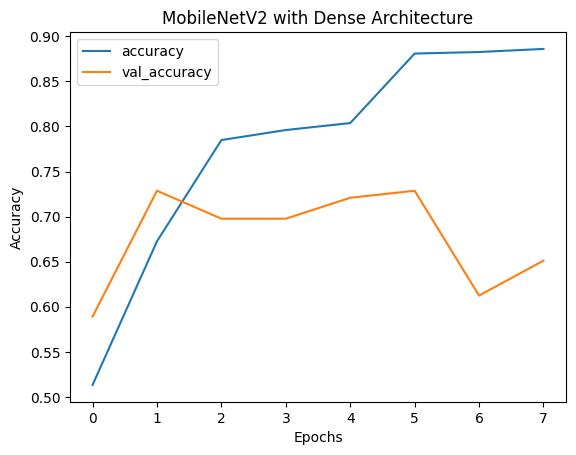

In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("MobileNetV2 with Dense Architecture")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/mobilenetV2_with_dense_architecture_accuracy.jpg")

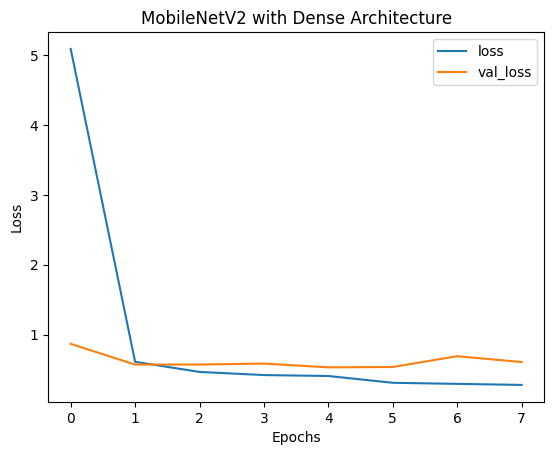

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("MobileNetV2 with Dense Architecture")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/MobileNetV2_with_dense_architecure_loss.jpg")

# Training Mobile Net V2 with Global pooling Average

In [ ]:
base_model_mobilenet = tf.keras.applications.MobileNetV2(include_top = False , input_shape = (256 , 256 , 3))
base_model_mobilenet.trainable = False

In [ ]:
input = Input(shape = (256 , 256 , 3))
model_mobilenet = base_model_mobilenet(input)
model_mobilenet = Conv2D(filters = 512 , kernel_size = (1 , 1) , activation = "relu")(model_mobilenet)
model_mobilenet = Conv2D(filters = 128 , kernel_size = (1 , 1) , activation = "relu")(model_mobilenet)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Dense(1 , activation = "sigmoid")(model_mobilenet)
model_mobilenet= Model(inputs = input , outputs = output_mobilenet)

In [ ]:
model_mobilenet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         655872    
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         65664     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 129 

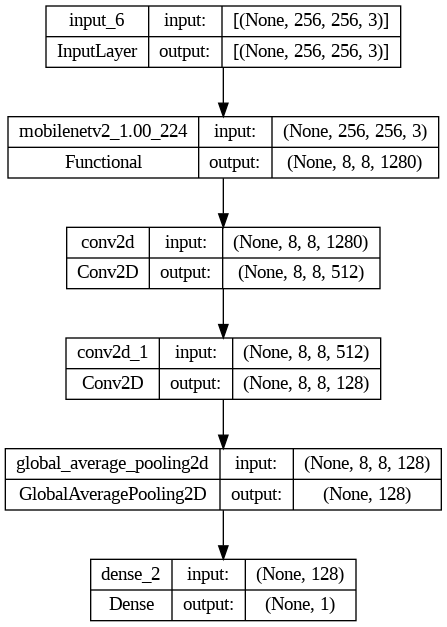

In [ ]:
plot_model(model_mobilenet, show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/MobileNetV2_with_GPA.png")

In [ ]:
model_mobilenet.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/mobilenetV2_with_GPA";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)


In [ ]:
history = model_mobilenet.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.7724 - accuracy: 0.5004

37/37 [==============================] - 67s 2s/step - loss: 0.7724 - accuracy: 0.5004 - val_loss: 0.6845 - val_accuracy: 0.5426
Epoch 2/30
36/37 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.5712

37/37 [==============================] - 29s 761ms/step - loss: 0.6701 - accuracy: 0.5724 - val_loss: 0.7584 - val_accuracy: 0.4961
Epoch 3/30
36/37 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5512

37/37 [==============================] - 27s 722ms/step - loss: 0.6797 - accuracy: 0.5510 - val_loss: 0.6610 - val_accuracy: 0.5969
Epoch 4/30
36/37 [============================>.] - ETA: 0s - loss: 0.6394 - accuracy: 0.6207

37/37 [==============================] - 33s 885ms/step - loss: 0.6380 - accuracy: 0.6221 - val_loss: 0.6862 - val_accuracy: 0.5349
Epoch 5/30
36/37 [============================>.] - ETA: 0s - loss: 0.6139 - accuracy: 0.6510

37/37 [==============================] - 27s 724ms/step - loss: 0.6120 - accuracy: 0.6538 - val_loss: 0.6367 - val_accuracy: 0.6589
Epoch 6/30
36/37 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.6658

37/37 [==============================] - 27s 715ms/step - loss: 0.5914 - accuracy: 0.6658 - val_loss: 0.6187 - val_accuracy: 0.6744
Epoch 7/30
36/37 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.6641

37/37 [==============================] - 27s 716ms/step - loss: 0.5854 - accuracy: 0.6650 - val_loss: 0.6498 - val_accuracy: 0.6047
Epoch 8/30
36/37 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7040

37/37 [==============================] - 27s 725ms/step - loss: 0.5426 - accuracy: 0.7052 - val_loss: 0.6296 - val_accuracy: 0.6822
Epoch 9/30
36/37 [============================>.] - ETA: 0s - loss: 0.5387 - accuracy: 0.7075

37/37 [==============================] - 28s 751ms/step - loss: 0.5390 - accuracy: 0.7069 - val_loss: 0.6444 - val_accuracy: 0.6899


In [ ]:
model_mobilenet.save("/content/drive/MyDrive/Final_year_project/models/mobilenetV2_with_GPA.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/MobileNetV2_with_GPA.csv")


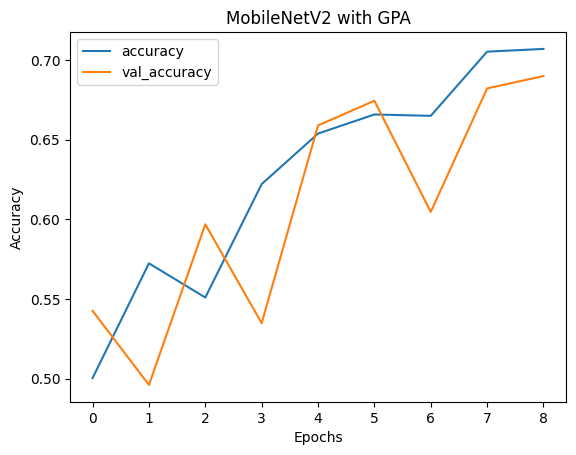

In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("MobileNetV2 with GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/mobilenetV2_with_GPA_accuracy.jpg")

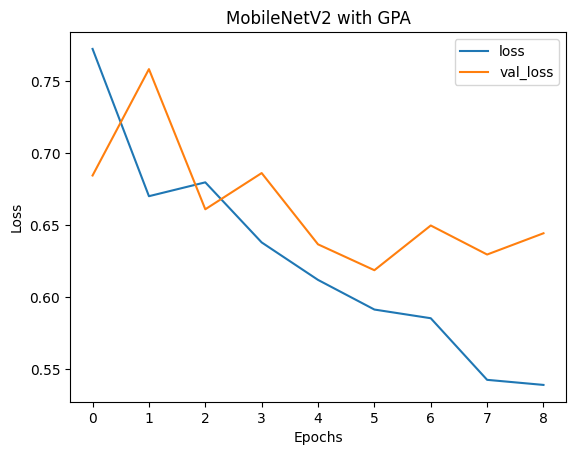

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("MobileNetV2 with GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/MobileNetV2_with_GPA_loss.jpg")

# Training Inception V3

In [ ]:
base_model_inceptionV3 = tf.keras.applications.InceptionV3(include_top = False , input_shape = (256 , 256 , 3))
base_model_inceptionV3.trainable = False

In [ ]:
input = Input(shape = (256 , 256 , 3))
inceptionV3 = base_model_inceptionV3(input)

inceptionV3 = Conv2D(512 , kernel_size = (1 , 1) , activation = "relu")(inceptionV3)
inceptionV3 = Conv2D(128 , kernel_size = (1 , 1) , activation = "relu")(inceptionV3)
inceptionV3 = GlobalAveragePooling2D()(inceptionV3)
output_inceptionV3 = Dense(1 , activation = "sigmoid")(inceptionV3)
inceptionV3 = Model(inputs = input , outputs = output_inceptionV3)

In [ ]:
inceptionV3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 6, 6, 512)         1049088   
                                                                 
 conv2d_95 (Conv2D)          (None, 6, 6, 128)         65664     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                             

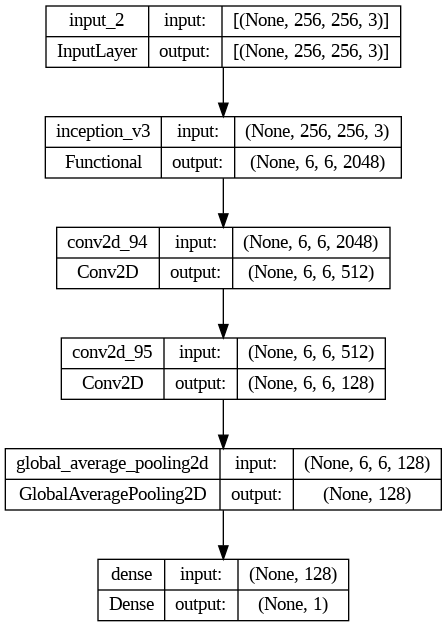

In [ ]:
plot_model(inceptionV3, show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/InceptionV3_with_GPA.png")

In [ ]:
inceptionV3.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/InceptionV3_with_GPA";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)


In [ ]:
history = inceptionV3.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 6.4846 - accuracy: 0.5047

37/37 [==============================] - 59s 1s/step - loss: 6.4846 - accuracy: 0.5047 - val_loss: 0.9395 - val_accuracy: 0.5349
Epoch 2/30
36/37 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.5599

37/37 [==============================] - 43s 1s/step - loss: 0.7632 - accuracy: 0.5613 - val_loss: 0.7524 - val_accuracy: 0.5504
Epoch 3/30
36/37 [============================>.] - ETA: 0s - loss: 0.7281 - accuracy: 0.5790

37/37 [==============================] - 45s 1s/step - loss: 0.7322 - accuracy: 0.5775 - val_loss: 0.8200 - val_accuracy: 0.4651
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.6024

37/37 [==============================] - 43s 1s/step - loss: 0.7005 - accuracy: 0.6024 - val_loss: 0.6657 - val_accuracy: 0.6124
Epoch 5/30
37/37 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.6247

37/37 [==============================] - 43s 1s/step - loss: 0.6234 - accuracy: 0.6247 - val_loss: 0.6283 - val_accuracy: 0.6434
Epoch 6/30
37/37 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6221

37/37 [==============================] - 43s 1s/step - loss: 0.6521 - accuracy: 0.6221 - val_loss: 0.6475 - val_accuracy: 0.6434
Epoch 7/30
37/37 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.6281

37/37 [==============================] - 43s 1s/step - loss: 0.6458 - accuracy: 0.6281 - val_loss: 0.6788 - val_accuracy: 0.5736
Epoch 8/30
37/37 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6452

37/37 [==============================] - 45s 1s/step - loss: 0.6337 - accuracy: 0.6452 - val_loss: 0.6486 - val_accuracy: 0.6047


In [ ]:
inceptionV3.save("/content/drive/MyDrive/Final_year_project/models/InceptionV3_with_GPA.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/InceptionV3_with_GPA.csv")


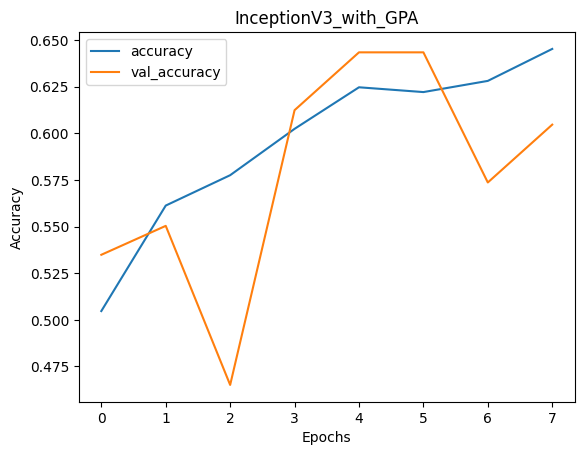

In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("InceptionV3_with_GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/InceptionV3_with_GPA.jpg")

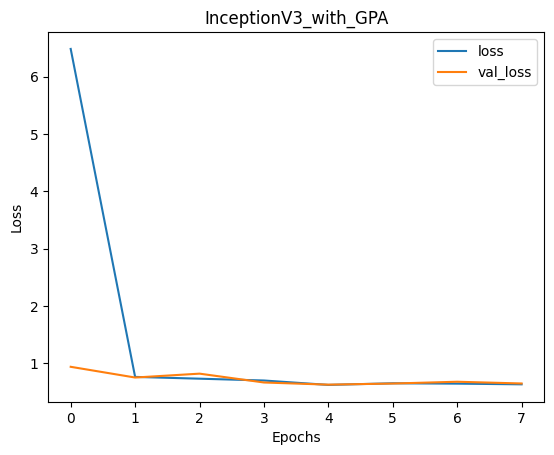

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("InceptionV3_with_GPA")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/InceptionV3_with_GPA.jpg")

# Custom CNN Model 1

In [ ]:
model = Sequential()

model.add(Conv2D(32 , kernel_size = (3 , 3) , activation = "relu" , input_shape = (256 , 256 , 3)))
model.add(Conv2D(32 , kernel_size = (3 , 3) , activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64 , kernel_size = (3 , 3) , activation = "relu"))
model.add(Conv2D(64 , kernel_size = (3 , 3) , activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128 , kernel_size = (3 , 3) , activation = "relu"))
model.add(Conv2D(128 , kernel_size = (3 , 3) , activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256 , kernel_size = (3 , 3) , activation = "relu"))
model.add(Conv2D(256 , kernel_size = (3 , 3) , activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128 , kernel_size = (1 , 1) , activation = "relu"))
model.add(Conv2D(128 , kernel_size = (1 , 1) , activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64 , kernel_size = (1 , 1) , activation = "relu"))
model.add(Conv2D(64 , kernel_size = (1 , 1) , activation = "relu"))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
model.add(Dense(128 , activation = "relu"))
model.add(Dense(1 , activation = "sigmoid"))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_178 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 conv2d_179 (Conv2D)         (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_180 (Conv2D)         (None, 124, 124, 64)      18496     
                                                                 
 conv2d_181 (Conv2D)         (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                

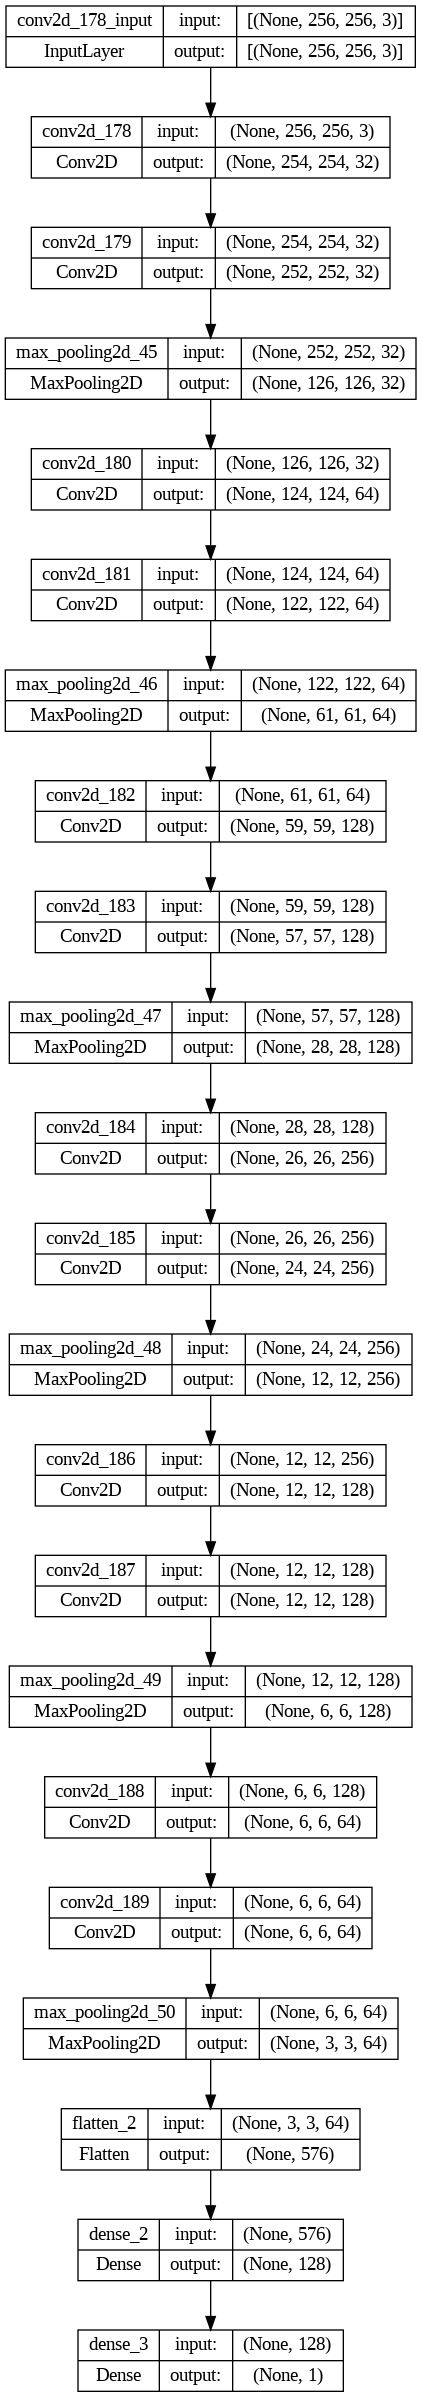

In [ ]:
plot_model(model, show_shapes = True , to_file = "/content/drive/MyDrive/Final_year_project/plots/Custom_CNN_1.png")

In [ ]:
model.compile(optimizer = "adam" ,  loss= "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
model_ckpt = "/content/drive/MyDrive/Final_year_project/models/Custom_CNN_1";
modelcheckpoint = ModelCheckpoint(model_ckpt)
earlystopping = EarlyStopping(patience = 3 , restore_best_weights= True)


In [ ]:
history = model.fit(train_ds , validation_data = validation_ds , epochs = 30 , callbacks = [modelcheckpoint , earlystopping])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.5013

37/37 [==============================] - 24s 350ms/step - loss: 1.0020 - accuracy: 0.5013 - val_loss: 0.6966 - val_accuracy: 0.4419
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.4781

37/37 [==============================] - 11s 263ms/step - loss: 0.6950 - accuracy: 0.4781 - val_loss: 0.6911 - val_accuracy: 0.5581
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.4893

37/37 [==============================] - 10s 252ms/step - loss: 0.6940 - accuracy: 0.4893 - val_loss: 0.6915 - val_accuracy: 0.5504
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5193

37/37 [==============================] - 11s 287ms/step - loss: 0.6938 - accuracy: 0.5193 - val_loss: 0.6964 - val_accuracy: 0.4419
Epoch 5/30
37/37 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.4850

37/37 [==============================] - 10s 255ms/step - loss: 0.6929 - accuracy: 0.4850 - val_loss: 0.6971 - val_accuracy: 0.4419


In [ ]:
model.save("/content/drive/MyDrive/Final_year_project/models/Custom_CNN_1.h5")

In [ ]:
pd.DataFrame(history.history).to_csv("/content/drive/MyDrive/Final_year_project/Stats/Custom_CNN_1.csv")


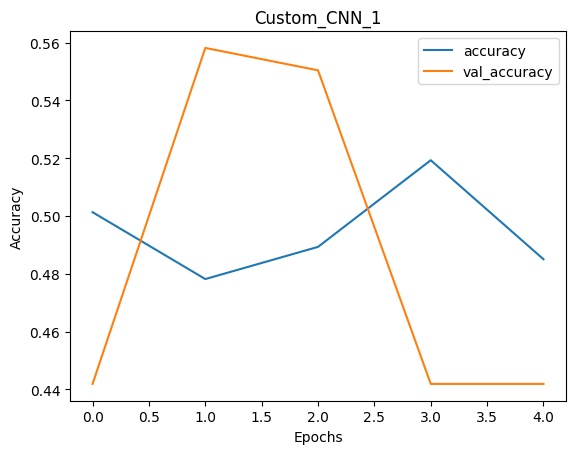

In [ ]:
pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Custom_CNN_1")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/Custom_CNN_1_accuracy.jpg")

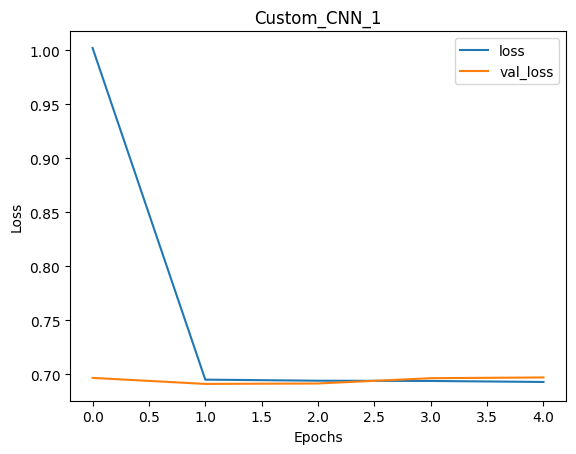

In [ ]:
pd.DataFrame(history.history)[["loss" , "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Custom_CNN_1")
plt.savefig("/content/drive/MyDrive/Final_year_project/plots/Custom_CNN_1_loss.jpg")

# Data Preprocessing

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Final_year_project/dataset/PD/NewSpiral.csv")

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
df.head()

,_ID_EXAM,IMAGE_NAME,ID_PATIENT,CLASS_TYPE,GENDER,RIGH/LEFT-HANDED,AGE,RMS,MAX_BETWEEN_ET_HT,MIN_BETWEEN_ET_HT,STD_DEVIATION_ET_HT,MRT,MAX_HT,MIN_HT,STD_HT,CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT
0,H1,sp1-H1.jpg,59,1,M,R,58,14900.772670,13207.241210,40856.39894,0.087041,56.978320,192.737170,0.026662,4394.307090,0.120773
1,H2,sp1-H2.jpg,76,1,M,R,60,6076.106534,9440.754502,36137.73814,0.065872,39.597318,169.753376,0.266595,2031.447046,0.172414
2,H3,sp1-H3.jpg,301,1,F,R,56,12220.462340,12247.263300,39871.73569,0.000000,46.183810,192.536776,0.007857,3843.754479,0.123894
3,H4,sp1-H4.jpg,102,1,M,R,24,4810.072073,4904.029458,32262.38975,0.044374,31.485790,200.401229,0.114530,1586.941716,0.162011
4,H5,sp1-H5.jpg,305,1,M,R,79,5458.875925,5911.591981,31795.46792,0.040906,47.231442,134.897863,0.026703,2251.866128,0.202899


In [ ]:
df.shape

(264, 16)

In [ ]:
df['ID_PATIENT'].value_counts()

23     8
31     8
5      8
59     4
21     4
143    4
38     4
47     4
53     4
235    4
253    4
261    4
268    4
273    4
281    4
247    4
149    4
157    4
165    4
186    4
192    4
196    4
207    4
218    4
203    4
224    4
153    4
176    4
181    4
230    4
138    4
22     4
20     4
76     4
19     4
301    4
102    4
305    4
104    4
127    4
297    4
299    4
98     4
78     4
80     4
86     4
1      4
2      4
3      4
4      4
6      4
7      4
8      4
9      4
11     4
12     4
13     4
14     4
15     4
16     4
17     4
18     4
187    4
Name: ID_PATIENT, dtype: int64

In [ ]:
df.drop(columns='IMAGE_NAME',inplace=True)

In [ ]:
pd.pivot_table(df,index='CLASS_TYPE',values='AGE',aggfunc=np.mean)

,AGE
CLASS_TYPE,
1,44.057143
2,57.838710


In [ ]:
df['CLASS_TYPE'].value_counts()

1    140
2    124
Name: CLASS_TYPE, dtype: int64

In [ ]:
pd.pivot_table(df,index='CLASS_TYPE',values='RMS',aggfunc=np.mean)

,RMS
CLASS_TYPE,
1,6283.068098
2,4781.939637


In [ ]:
pd.pivot_table(df,index='CLASS_TYPE',values='MAX_BETWEEN_ET_HT',aggfunc=np.mean)

,MAX_BETWEEN_ET_HT
CLASS_TYPE,
1,7187.910232
2,6863.717790


In [ ]:
Y=df['CLASS_TYPE']

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
df.GENDER= le.fit_transform(df.GENDER.values)

In [ ]:
df['RIGH/LEFT-HANDED'] = le.fit_transform(df['RIGH/LEFT-HANDED'].values)

In [ ]:
X=df

In [ ]:
X.columns

Index(['_ID_EXAM', 'ID_PATIENT', 'CLASS_TYPE', 'GENDER', 'RIGH/LEFT-HANDED',
       'AGE', 'RMS', 'MAX_BETWEEN_ET_HT', 'MIN_BETWEEN_ET_HT',
       'STD_DEVIATION_ET_HT', 'MRT', 'MAX_HT', 'MIN_HT', 'STD_HT',
       'CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT'],
      dtype='object')

In [ ]:
X.drop(columns=['_ID_EXAM','ID_PATIENT'],inplace=True)

In [ ]:
X.drop(columns=['CLASS_TYPE'],inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.25, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
st_x= StandardScaler()
x_train= st_x.fit_transform(x_train)
x_test= st_x.transform(x_test)

#SVM


In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(x_train, y_train)

SVC(random_state=0)

In [ ]:
y_pred= classifier.predict(x_test)

In [ ]:
classifier.score(x_train, y_train)

0.8737373737373737

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test , y_pred)

0.8333333333333334

In [ ]:
svm_model='/content/drive/MyDrive/Final_year_project/models/SVM/svm.joblib'

In [ ]:
import joblib

In [ ]:
joblib.dump(classifier,svm_model)

['/content/drive/MyDrive/Final_year_project/models/SVM/svm.joblib']

Text(0.5, 1.0, 'Confusion Matrix for SVM model')

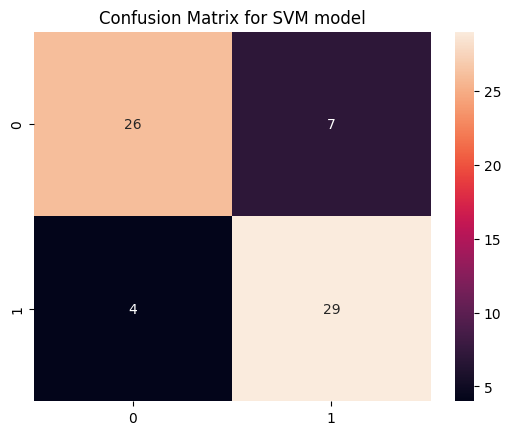

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred) , annot = True , fmt = "d")
plt.title("Confusion Matrix for SVM model")

# MLP


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlc=MLPClassifier(hidden_layer_sizes=(25 , 15), max_iter=5000,random_state=0,alpha=0.0001,solver="lbfgs",verbose=True)

In [ ]:
mlc.fit(x_train,y_train)


MLPClassifier(hidden_layer_sizes=(25, 15), max_iter=5000, random_state=0,
              solver='lbfgs', verbose=True)

In [ ]:
# training accuracy

Y_pred_train = mlc.predict(x_train)
accuracy_score(y_train , Y_pred_train)

0.9949494949494949

In [ ]:
# training accuracy

y_pred = mlc.predict(x_test)
accuracy_score(y_test , y_pred)

0.7727272727272727

Text(0.5, 1.0, 'Confusion Matrix for MLP model')

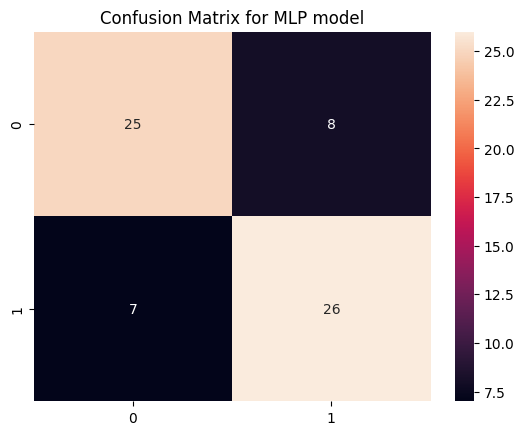

In [ ]:

sns.heatmap(confusion_matrix(y_test, y_pred) , annot = True , fmt = "d")
plt.title("Confusion Matrix for MLP model")

# hyperparameter Tuning

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear','poly']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [100,150],
            'randomforestclassifier__criterion': ['gini','entropy']


        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'logisticregression__C': [1,0.5,0.2],
            'logisticregression__solver':['liblinear']

        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=True)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

    joblib.dump(clf , os.path.join("/content/drive/MyDrive/Final_year_project/models", algo  + ".joblib"))
df1 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df1

# Multi Modal for ML techique

In [1]:
svm = joblib.load("/content/drive/MyDrive/Final_year_project/models/svm.joblib")

NameError: ignored

In [ ]:
random_forest = joblib.load("/content/drive/MyDrive/Final_year_project/models/random_forest.joblib")

In [ ]:
logistic_regression = joblib.load("/content/drive/MyDrive/Final_year_project/models/logistic_regression.joblib")

In [ ]:
estimators = []

#Defining 5 Logistic Regression Models
model1 = LogisticRegression(penalty = 'l2', random_state = 0 , solver = "liblinear")
estimators.append(('logistic1', model1))
model2 = LogisticRegression(penalty = 'l1', random_state = 0 , solver = "liblinear")
estimators.append(('logistic2', model2))
model3 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic3', model3))
model4 = LogisticRegression(penalty = 'l2', random_state = 0 , solver = "newton-cg")
estimators.append(('logistic4', model4))
model5 = LogisticRegression(penalty = 'l2', random_state = 0 , solver = "saga")
estimators.append(('logistic5', model5))
model6 = LogisticRegression(penalty = 'l1', random_state = 0 , solver = "saga")
estimators.append(('logistic6', model6))


#Defining 5 Support Vector Classifiers
model8 = SVC(kernel = 'linear')
estimators.append(('svm1', model8))
model9 = SVC(kernel = 'poly')
estimators.append(('svm2', model9))
model10 = SVC(kernel = 'rbf')
estimators.append(('svm3', model10))

# Defining 5 Random Forest Classifer


model11 = RandomForestClassifier(n_estimators = 100 , criterion = "gini")
estimators.append(('RandomForest1' , model11))
model12 = RandomForestClassifier(n_estimators = 100 , criterion = "entropy")
estimators.append(('RandomForest2' , model12))
model13 = RandomForestClassifier(n_estimators = 125 , criterion = "gini")
estimators.append(('RandomForest3' , model13))
model14 = RandomForestClassifier(n_estimators = 125 , criterion = "entropy")
estimators.append(('RandomForest4' , model14))
model15 = RandomForestClassifier(n_estimators = 150 , criterion = "gini")
estimators.append(('RandomForest5' , model15))
model16 = RandomForestClassifier(n_estimators = 150 , criterion = "entropy")
estimators.append(('RandomForest6' , model16))

In [ ]:
estimators

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
ensembled_model = VotingClassifier(estimators)
ensembled_model.fit(x_train , y_train)

In [ ]:
y_pred = ensembled_model.predict(x_test)

In [ ]:
accuracy_score(y_test , y_pred) # For Multi Model

In [ ]:
sns.heatmap(confusion_matrix(y_test , y_pred ) , annot = True  , fmt = "d")